# Machine Learning Models

Continuation of notes about SciPy2019 talk by Aileen Nielsen.

[Original notebook](https://github.com/PracticalTimeSeriesAnalysis/BookRepo/blob/master/Ch09/Classification.ipynb) contains much more code than I chose to play with here.

## Time series feature generation

There are no (none at all?) machine learning algorithms that have been specifically developed for handling time series models. Indeed, many ml algorithms do not support the notion of temporal data. Therefore, it is necessary to make your time series data fit into a representation that the ml algorithm in question does support. For example, Decision Trees are not built to handle temporal data.

You can handle this mismatch by generating suitable features from your time series data. For example, record the minimum and maximum values (and time stamps?), count the number of peaks and valleys in time windows, compute the mean and median over such windows.

If you have many time series that span long periods of time and compute such features once every minute (or whatever the time step in your data is), then this can become computationally expensive.

There are canonical feature sets that have been developed for time series. According to Aileen, if you have a specific use case / domain, you should be able to do better than a canonical feature set using domain knowledge and analyzing your data. Time series features are discipline-specific. 

This may be true, but still wondering what to do when faced with very large multivariate time series datas sets. 

A few of the models being discussed:
* Random Forests using xgboost. You learn your first decision tree and then learn the second one based on the errors of the first one. In practice, xgboost is said to perform well with time series classification.
* Clustering. Difficult both conceptually and due to computational costs. Need to be careful to pick a good distance metric (e.g., not Euclidean distance). Need to be careful that you really cluster time series with similar features. Put differently, you need to find features that distinguish well between different time series (domain knowledge?).
  * Clustering can be based on features that you identify in time series (e.g., either by looking for the features from a canonical set or with custom-code to look for relevant features in your domain). This can become computationally expensive. Think thousands of time series each with tens of thousands of data points you need to analyze.
  * Clustering can also be done using a suitable distance metric. The one recommended for time series data is [Dynamic Time Warping](https://en.wikipedia.org/wiki/Dynamic_time_warping).


## Classification using trees

I could not get the `featurize` import from `cesium` to work. Instead, I have made use of a ready-made file of features. Just know that there are several packages out there to help with time series feature extraction in Matlab, R, and Python. The features are based on a configuration in the form of a list of feature names passed to `cesium` (configuration is not shown here).

In [2]:
import matplotlib.pyplot as plt
import cesium
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time

from cesium import datasets
#from cesium import featurize as ft

import scipy
from scipy.stats import pearsonr, spearmanr
from scipy.stats import skew

import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

plt.rcParams["figure.figsize"] = [10, 10]

There are packages that can extract features from time series. `cesium` is one such package. More [details](https://github.com/cesium-ml/cesium), including the list of features, such as number of peaks, index of $i^{th}$ largest peak, total number of observed values, difference between maximum and minimum time values, mean of time values, amplitude, skewness and many more. Apparently, there are more than 7,700 time series features :dizzy_face:

In [3]:
eeg = datasets.fetch_andrzejak()

In [4]:
type(eeg)

dict

In [5]:
eeg.keys()

dict_keys(['times', 'measurements', 'classes', 'archive', 'header'])

In [39]:
print(f'Type of measurements: {type(eeg["measurements"][0])}')
print(f'Len: {len(eeg["measurements"])})')
print(f'Dimensions: {eeg["measurements"][0].shape}')
eeg["measurements"][0:50:10]

Type of measurements: <class 'numpy.ndarray'>
Len: 500)
Dimensions: (4097,)


[array([ 40.,  48.,  35., ..., -34., -27., -42.]),
 array([ 14.,  25.,  31., ..., -26., -28.,  21.]),
 array([-58., -59., -60., ..., -43., -59.,  23.]),
 array([-21., -29., -34., ...,  18.,   6.,  25.]),
 array([ -45., -105., -106., ...,   22.,    5.,   96.])]

500 rows with 4,097 elements or samples per row (if I read this correctly).

In [41]:
print(f'Type of classes: {type(eeg["classes"][0])}')
print(f'Len: {len(eeg["classes"])})')
print(f'Dimensions: {eeg["classes"].shape}')
eeg["classes"]

Type of classes: <class 'numpy.str_'>
Len: 500)
Dimensions: (500,)


array(['Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z',
       'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z',
       'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z',
       'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z',
       'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z',
       'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z',
       'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z',
       'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'O', 'O', 'O', 'O',
       'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O',
       'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O',
       'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O',
       'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O',
       'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O',
       'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O

In [38]:
print(f'Type of times: {type(eeg["times"][0])}')
print(f'Len: {len(eeg["times"])})')
eeg["times"][0:50]

Type of times: <class 'numpy.ndarray'>
Len: 500)


[array([0.00000000e+00, 5.76171875e-03, 1.15234375e-02, ...,
        2.35884766e+01, 2.35942383e+01, 2.36000000e+01]),
 array([0.00000000e+00, 5.76171875e-03, 1.15234375e-02, ...,
        2.35884766e+01, 2.35942383e+01, 2.36000000e+01]),
 array([0.00000000e+00, 5.76171875e-03, 1.15234375e-02, ...,
        2.35884766e+01, 2.35942383e+01, 2.36000000e+01]),
 array([0.00000000e+00, 5.76171875e-03, 1.15234375e-02, ...,
        2.35884766e+01, 2.35942383e+01, 2.36000000e+01]),
 array([0.00000000e+00, 5.76171875e-03, 1.15234375e-02, ...,
        2.35884766e+01, 2.35942383e+01, 2.36000000e+01]),
 array([0.00000000e+00, 5.76171875e-03, 1.15234375e-02, ...,
        2.35884766e+01, 2.35942383e+01, 2.36000000e+01]),
 array([0.00000000e+00, 5.76171875e-03, 1.15234375e-02, ...,
        2.35884766e+01, 2.35942383e+01, 2.36000000e+01]),
 array([0.00000000e+00, 5.76171875e-03, 1.15234375e-02, ...,
        2.35884766e+01, 2.35942383e+01, 2.36000000e+01]),
 array([0.00000000e+00, 5.76171875e-03, 1.152343

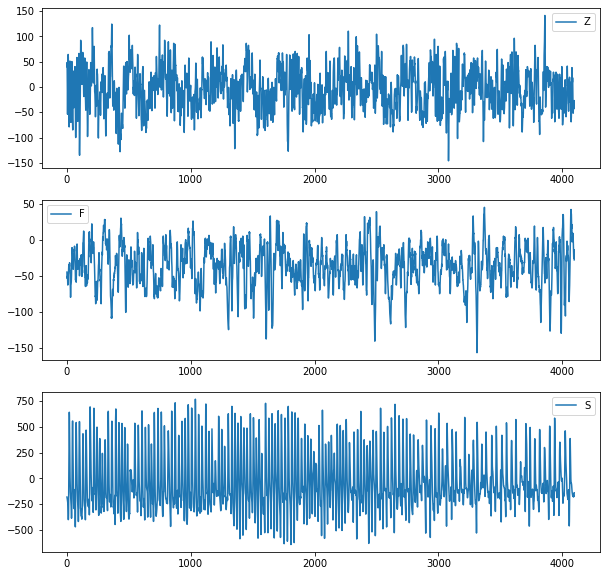

In [6]:
plt.subplot(3, 1, 1)
plt.plot(eeg["measurements"][0])
plt.legend(eeg['classes'][0])
plt.subplot(3, 1, 2)
plt.plot(eeg["measurements"][300])
plt.legend(eeg['classes'][300])
plt.subplot(3, 1, 3)
plt.plot(eeg["measurements"][450])
plt.legend(eeg['classes'][450])

In [42]:
# loading prepared features
fset_cesium = pd.read_csv("data/full_eeg_data_features.csv", header = [0, 1])

In [45]:
! head -n 3 data/full_eeg_data_features.csv

feature,amplitude,percent_beyond_1_std,percent_close_to_median,skew,max_slope
channel,0,0,0,0,0
0,143.5,0.3273126678057115,0.5050036612155235,0.03280499636078603,11107.796610166752


In [43]:
fset_cesium.head(10)

,feature,amplitude,percent_beyond_1_std,percent_close_to_median,skew,max_slope
,channel,0,0,0,0,0
0,0,143.5,0.327313,0.505004,0.032805,11107.796610
1,1,211.5,0.290212,0.640469,-0.092715,20653.559322
2,2,165.0,0.302660,0.515987,-0.004100,13537.627119
3,3,171.5,0.300952,0.541128,0.063678,17008.813559
4,4,170.0,0.305101,0.566268,0.142753,13016.949153
5,5,151.5,0.308763,0.524774,0.002501,10934.237288
6,6,162.0,0.308518,0.531853,0.003179,12843.389831
7,7,126.5,0.324628,0.565780,-0.023597,8851.525424
8,8,105.0,0.324140,0.491091,-0.002426,7463.050847


In [47]:
fset_cesium.shape

(500, 6)

By picking a handful of features, we have managed to digest $500 \times 4,097$ down to $500 \times 5$. Of course, this does not explain the art of magic of how to pick a set of features that matches your data and problem.

In [49]:
fset_cesium.head()

,feature,amplitude,percent_beyond_1_std,percent_close_to_median,skew,max_slope
,channel,0,0,0,0,0
0,0,143.5,0.327313,0.505004,0.032805,11107.796610
1,1,211.5,0.290212,0.640469,-0.092715,20653.559322
2,2,165.0,0.302660,0.515987,-0.004100,13537.627119
3,3,171.5,0.300952,0.541128,0.063678,17008.813559
4,4,170.0,0.305101,0.566268,0.142753,13016.949153


(array([311.,  85.,  30.,  19.,   8.,  13.,   7.,  14.,   7.,   6.]),
 array([  63. ,  241.5,  420. ,  598.5,  777. ,  955.5, 1134. , 1312.5,
        1491. , 1669.5, 1848. ]),
 <a list of 10 Patch objects>)

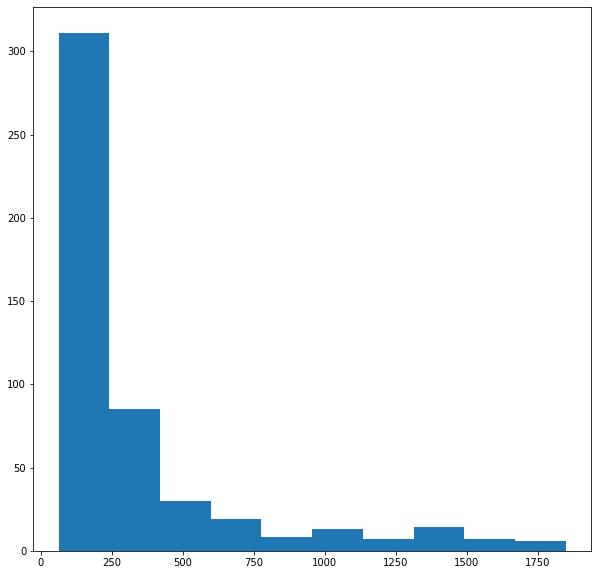

In [51]:
# select all rows, second column (which I think is amplitude) and plot as a histogram
plt.hist(fset_cesium.iloc[:, 1])

In [54]:
fset_cesium['classes'] = eeg['classes']
fset_cesium.columns = fset_cesium.columns.droplevel(-1)

In [55]:
fset_cesium.head()

,feature,amplitude,percent_beyond_1_std,percent_close_to_median,skew,max_slope,classes
0,0,143.5,0.327313,0.505004,0.032805,11107.796610,Z
1,1,211.5,0.290212,0.640469,-0.092715,20653.559322,Z
2,2,165.0,0.302660,0.515987,-0.004100,13537.627119,Z
3,3,171.5,0.300952,0.541128,0.063678,17008.813559,Z
4,4,170.0,0.305101,0.566268,0.142753,13016.949153,Z


classes
F    AxesSubplot(0.125,0.125;0.775x0.755)
N    AxesSubplot(0.125,0.125;0.775x0.755)
O    AxesSubplot(0.125,0.125;0.775x0.755)
S    AxesSubplot(0.125,0.125;0.775x0.755)
Z    AxesSubplot(0.125,0.125;0.775x0.755)
Name: amplitude, dtype: object

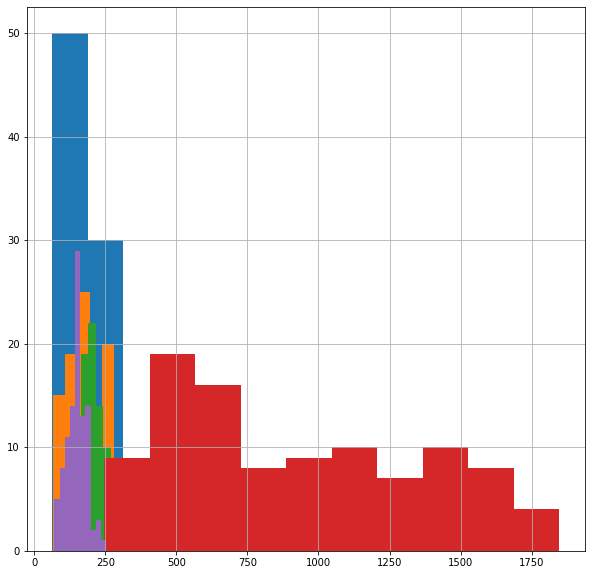

In [56]:
fset_cesium.groupby('classes')['amplitude'].hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c2d4b4810>,
      dtype=object)

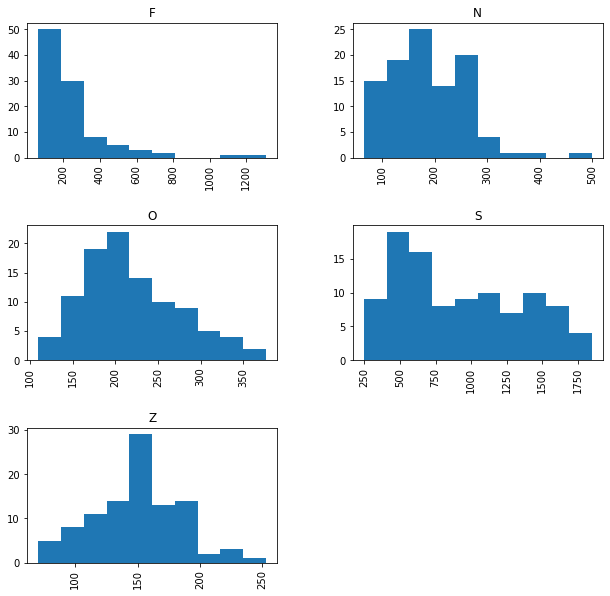

In [59]:
fset_cesium['amplitude'].hist(by=fset_cesium['classes'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c2d3a7110>,
      dtype=object)

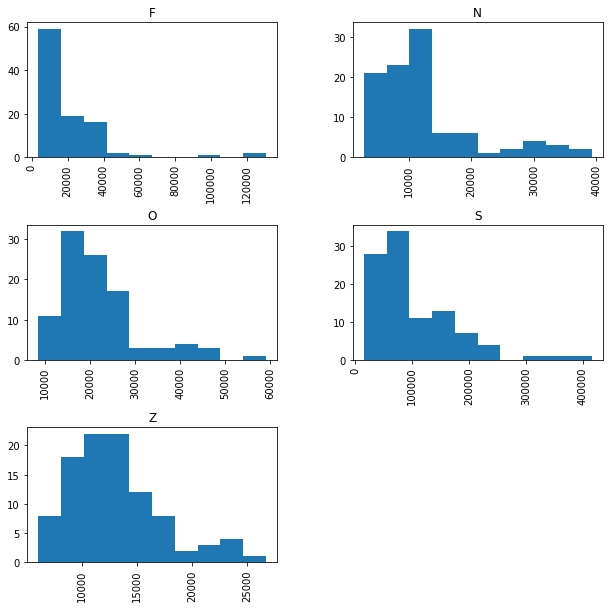

In [60]:
fset_cesium['max_slope'].hist(by=fset_cesium['classes'])

classes
F    AxesSubplot(0.125,0.125;0.775x0.755)
N    AxesSubplot(0.125,0.125;0.775x0.755)
O    AxesSubplot(0.125,0.125;0.775x0.755)
S    AxesSubplot(0.125,0.125;0.775x0.755)
Z    AxesSubplot(0.125,0.125;0.775x0.755)
Name: max_slope, dtype: object

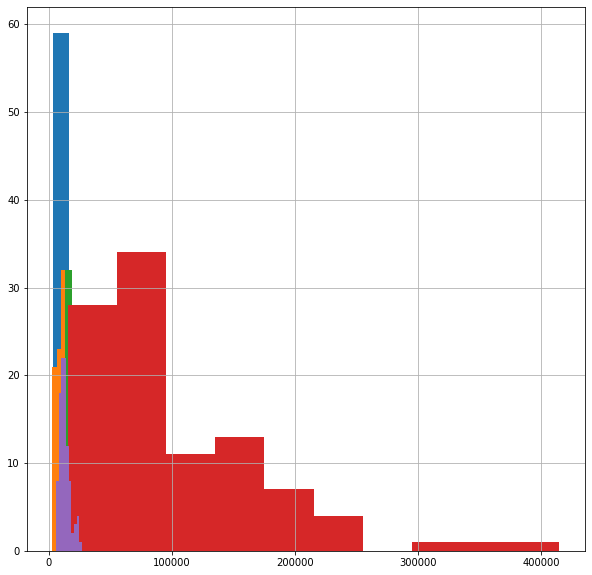

In [61]:
fset_cesium.groupby('classes')['max_slope'].hist()

### Train and evaluate a Random Forest

Want to train a Random Forest using some parameter-settings (just playing here) and then evaluate its accuracy by comparing it against a random model and by computing its F-1 score.

In [62]:
X_train, X_test, y_train, y_test = train_test_split(fset_cesium.iloc[:, 1:6].values, eeg["classes"], random_state=21)

In [63]:
clf_rf = RandomForestClassifier(n_estimators=10, max_depth=3, random_state=21)

In [64]:
clf_rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=3, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=21, verbose=0,
                       warm_start=False)

In [65]:
clf_rf.score(X_train, y_train)

0.6266666666666667

In [66]:
clf_rf.score(X_test, y_test)

0.616

In [67]:
y_pred = clf_rf.predict(X_test)

In [69]:
from sklearn import metrics

In [75]:
print(f"RF Accuracy: {metrics.accuracy_score(y_test, y_pred)}")

RF Accuracy: 0.616


I am using a weighted approach to compute precision in a multi-class setting. A very readable introduction into how to evaluate the performance of classifiers for multi-class problems can be found in a two-part blog post titled Multi-Class Metrics Made Simple [part 1](https://towardsdatascience.com/multi-class-metrics-made-simple-part-i-precision-and-recall-9250280bddc2) and [part 2](https://towardsdatascience.com/multi-class-metrics-made-simple-part-ii-the-f1-score-ebe8b2c2ca1).

In [74]:
print(f"RF Precision: {metrics.precision_score(y_test, y_pred, average='weighted')}")

RF Precision: 0.60517068364081


In [77]:
print(f"RF Recall: {metrics.recall_score(y_test, y_pred, average='weighted')}")

RF Revall: 0.616


In [78]:
print(f"RF F-1 score: {metrics.f1_score(y_test, y_pred, average='weighted')}")

RF F-1 score: 0.5968477692080176


In [79]:
print(metrics.classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

           F      0.333     0.200     0.250        20
           N      0.550     0.379     0.449        29
           O      0.581     0.857     0.692        21
           S      0.957     0.880     0.917        25
           Z      0.564     0.733     0.638        30

    accuracy                          0.616       125
   macro avg      0.597     0.610     0.589       125
weighted avg      0.605     0.616     0.597       125

